In [2]:
pip install pyspark

Note: you may need to restart the kernel to use updated packages.


In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Energy Analysis") \
    .getOrCreate()

24/05/12 14:46:01 WARN Utils: Your hostname, MacBook-Pro-2.local resolves to a loopback address: 127.0.0.1; using 10.0.0.216 instead (on interface en0)
24/05/12 14:46:01 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/12 14:46:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/05/12 14:46:14 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [4]:
# Assuming the files are stored in your working directory
df = spark.read.csv("Downloads/Energy_Usage_2010_20240512.csv", header=True, inferSchema=True)

In [5]:
df.head()

24/05/12 14:46:30 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Row(COMMUNITY AREA NAME='Archer Heights', CENSUS BLOCK=170315704001006, BUILDING TYPE='Residential', BUILDING_SUBTYPE='Multi < 7', KWH JANUARY 2010=None, KWH FEBRUARY 2010=None, KWH MARCH 2010=None, KWH APRIL 2010=None, KWH MAY 2010=None, KWH JUNE 2010=None, KWH JULY 2010=None, KWH AUGUST 2010=None, KWH SEPTEMBER 2010=None, KWH OCTOBER 2010=None, KWH NOVEMBER 2010=None, KWH DECEMBER 2010=None, TOTAL KWH=None, ELECTRICITY ACCOUNTS=None, ZERO KWH ACCOUNTS=0, THERM JANUARY 2010=2326, THERM FEBRUARY 2010=2131, THERM MARCH 2010=1400, TERM APRIL 2010=620, THERM MAY 2010=502, THERM JUNE 2010=224, THERM JULY 2010=222, THERM AUGUST 2010=187, THERM SEPTEMBER 2010=197, THERM OCTOBER 2010=252, THERM NOVEMBER 2010=744, THERM DECEMBER 2010=2112, TOTAL THERMS=10917, GAS ACCOUNTS='11', KWH TOTAL SQFT=None, THERMS TOTAL SQFT=11134, KWH MEAN 2010=None, KWH STANDARD DEVIATION 2010=None, KWH MINIMUM 2010=None, KWH 1ST QUARTILE 2010=None, KWH 2ND QUARTILE 2010=None, KWH 3RD QUARTILE 2010=None, KWH MAXIMUM 

In [8]:
# Print the schema of the DataFrame to understand data types
df.printSchema()

root
 |-- COMMUNITY AREA NAME: string (nullable = true)
 |-- CENSUS BLOCK: long (nullable = true)
 |-- BUILDING TYPE: string (nullable = true)
 |-- BUILDING_SUBTYPE: string (nullable = true)
 |-- KWH JANUARY 2010: integer (nullable = true)
 |-- KWH FEBRUARY 2010: integer (nullable = true)
 |-- KWH MARCH 2010: integer (nullable = true)
 |-- KWH APRIL 2010: integer (nullable = true)
 |-- KWH MAY 2010: integer (nullable = true)
 |-- KWH JUNE 2010: integer (nullable = true)
 |-- KWH JULY 2010: integer (nullable = true)
 |-- KWH AUGUST 2010: integer (nullable = true)
 |-- KWH SEPTEMBER 2010: integer (nullable = true)
 |-- KWH OCTOBER 2010: integer (nullable = true)
 |-- KWH NOVEMBER 2010: integer (nullable = true)
 |-- KWH DECEMBER 2010: integer (nullable = true)
 |-- TOTAL KWH: integer (nullable = true)
 |-- ELECTRICITY ACCOUNTS: string (nullable = true)
 |-- ZERO KWH ACCOUNTS: integer (nullable = true)
 |-- THERM JANUARY 2010: integer (nullable = true)
 |-- THERM FEBRUARY 2010: integer (n

In [9]:
# Get a summary of the numerical fields
df.describe().show()

+-------+-------------------+--------------------+-------------+----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+-----------------+------------------+-------------------+------------------+------------------+------------------+-----------------+-----------------+-----------------+--------------------+------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+------------------+---------------------------+------------------+---------------------+---------------------+---------------------+------------------+------------------+--------------------------------+---------------------+--------------------------+--------------------------+--------------------------+---------------------

In [11]:
# Example: Dropping rows with any missing values
df = df.na.drop()

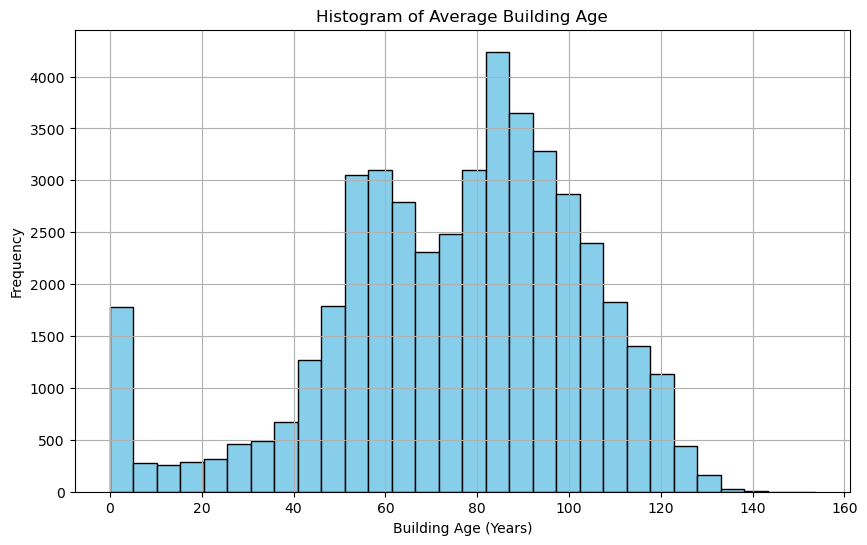

In [15]:
import matplotlib.pyplot as plt 


# 1. Histogram of Average Building Age (Plotting will be done in Matplotlib)
building_age = df.select("AVERAGE BUILDING AGE").na.drop().rdd.flatMap(lambda x: x).collect()
plt.figure(figsize=(10, 6))
plt.hist(building_age, bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Average Building Age')
plt.xlabel('Building Age (Years)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

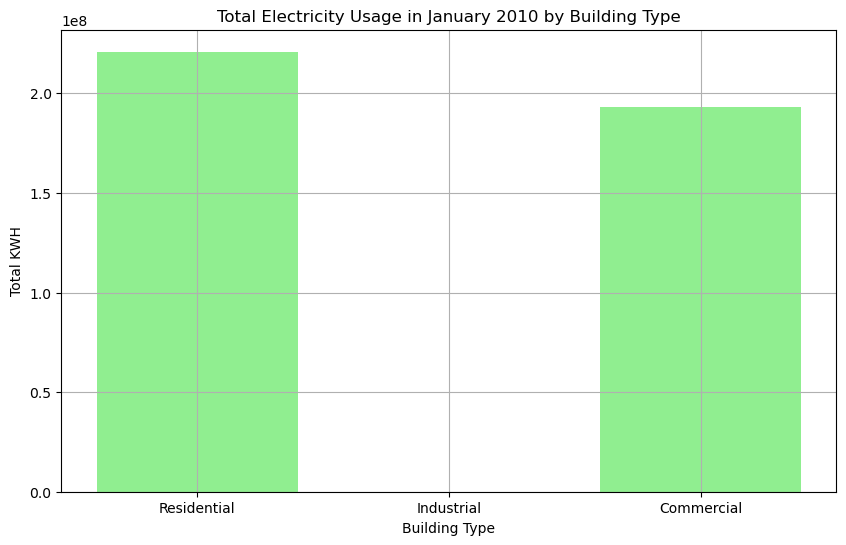

In [17]:
# 2. Bar Chart of Total Electricity Usage in January 2010 by Building Type
kwh_by_type = df.groupBy("BUILDING TYPE").sum("KWH JANUARY 2010").toPandas()
plt.figure(figsize=(10, 6))
plt.bar(kwh_by_type['BUILDING TYPE'], kwh_by_type['sum(KWH JANUARY 2010)'], color='lightgreen')
plt.title('Total Electricity Usage in January 2010 by Building Type')
plt.xlabel('Building Type')
plt.ylabel('Total KWH')
plt.grid(True)
plt.show()

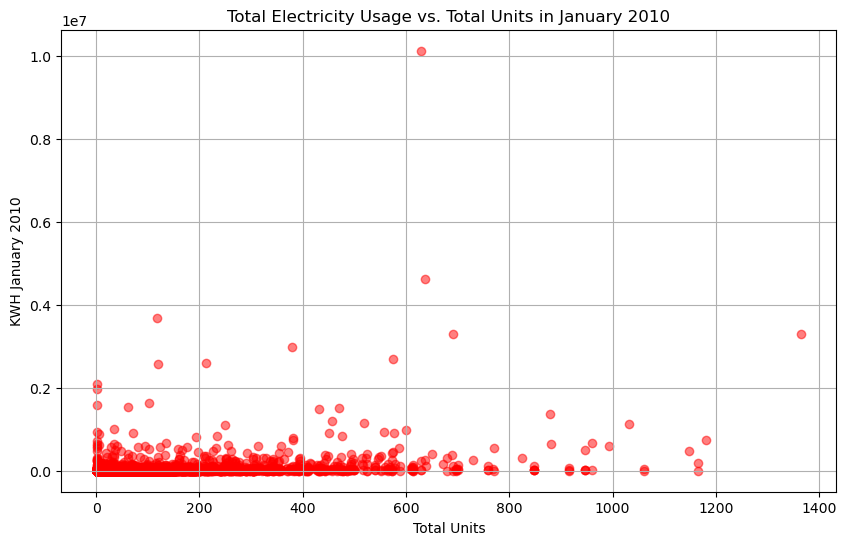

In [18]:
# 3. Scatter Plot of Total Electricity Usage vs Total Units
kwh_vs_units = df.select("TOTAL UNITS", "KWH JANUARY 2010").na.drop().toPandas()
plt.figure(figsize=(10, 6))
plt.scatter(kwh_vs_units['TOTAL UNITS'], kwh_vs_units['KWH JANUARY 2010'], alpha=0.5, color='red')
plt.title('Total Electricity Usage vs. Total Units in January 2010')
plt.xlabel('Total Units')
plt.ylabel('KWH January 2010')
plt.grid(True)
plt.show()

In [23]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.types import IntegerType, FloatType
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import pyspark.sql.functions as F  # Correct import for using F

In [24]:
# Define a new column 'label' for classification purposes: 1 for high usage, 0 for low usage
average_kwh = df.agg({"KWH JANUARY 2010": "avg"}).collect()[0][0]
df = df.withColumn("label", F.when(df["KWH JANUARY 2010"] >= average_kwh, 1).otherwise(0))

In [45]:
# Feature engineering with a broader set of features
assembler = VectorAssembler(
    inputCols=[
        "AVERAGE BUILDING AGE", "TOTAL UNITS", "AVERAGE STORIES", "AVERAGE HOUSESIZE",
        "OCCUPIED UNITS PERCENTAGE", "RENTER-OCCUPIED HOUSING PERCENTAGE", "TOTAL POPULATION",
        "OCCUPIED HOUSING UNITS", "KWH FEBRUARY 2010", "KWH MARCH 2010", "KWH APRIL 2010",
        "KWH MAY 2010", "KWH JUNE 2010"
    ],
    outputCol="features")

In [46]:
# Index labels, adding metadata to the label column.
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(df)

In [47]:
# Initialize Random Forest classifier model
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="features", numTrees=30)

In [48]:
# Chain indexers and model in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, assembler, rf])

In [49]:
# Split data into training and test sets
train_data, test_data = df.randomSplit([0.8, 0.2])

In [50]:
# Train model
model = pipeline.fit(train_data)

In [51]:
# Make predictions
predictions = model.transform(test_data)

# Evaluate model
evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

In [52]:
print(f"Model accuracy: {accuracy}")

Model accuracy: 0.9217834671295292


In [53]:
from pyspark.ml.classification import GBTClassifier

In [54]:
# Initialize GBT classifier model
gbt = GBTClassifier(labelCol="indexedLabel", featuresCol="features", maxIter=20)

# Chain indexers and model in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, assembler, gbt])

In [59]:
# Train model
model_gbt = pipeline.fit(train_data)

# Make predictions
predictions_gbt = model_gbt.transform(test_data)

In [60]:
# Evaluate model
evaluator_gbt = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy_gbt = evaluator.evaluate(predictions_gbt)

print(f"Model accuracy: {accuracy_gbt}")

Model accuracy: 0.9236276849642004
